# Probabilistic Graphical Models

Table of Contents:


In [2]:
# Libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras.datasets import mnist
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

# plotting defaults
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (8, 6)

Using TensorFlow backend.


---
# Representation

Bayes net deals with DAGs, markov random fields deal with undirected graphs

## [1. Bayesian Networks](https://ermongroup.github.io/cs228-notes/representation/directed/)

<img src="https://ermongroup.github.io/cs228-notes/assets/img/grade-model.png" width="500" />

- If $P(x, y) = P(x)P(y) \rightarrow x \perp y \in I(p), \text{the set of all independencies}$

- $d$-separation (directed separation)
    - $Q, W$ are $d$-separated given $O$, set of observed variables if they are **not** connected by an **active path**
        - **Intuition**: When a path is **activated** it means that there is a dependency created from the source to the sink, meaning that the source and sink won't be $d$-separated and hence dependent
        - **Active path**: A path in a graph $G$ such that for every consecutive triplet of variables, one of the following pattern holds **given observed variables $O$**:
            - $X \leftarrow Y \leftarrow Z,$ and $Y$ is unobserved $Y \not\in O$ [Cascade / Causal Chains]
            - $X \rightarrow Y \rightarrow Z,$ and $Y$ is unobserved $Y \not\in O$ [Cascade / Causal Chains]
                - $X$ and $Z$ alone are not independent
                - Only when $Y$ is observed, then we can say that $X \perp Z \mid Y$
                - Evidence along the chain **blocks** the influence
            - $X \leftarrow Y \rightarrow Z,$ and $Y$ is unobserved $Y \not\in O$ [Common Cause / Common Parent]
                - $X$ and $Z$ alone are not independent
                - Only when $Y$ is observed, then we can say that $X \perp Z \mid Y$
                - Observing the cause $Y$ **blocks** the influence between effects
            - $X \rightarrow Y \leftarrow Z,$ and $Y$ or any of its descendants are observed $\in O$ [Common Effect / $V$-structure]
                - $X$ and $Z$ alone are independent in this case when $Y$ is not observed
                - When $Y$ is observed, $X$ and $Y$ competes for being the explanation of $Y$
                - Observing an effect **activates** influence between possible causes
    - Summary: 
        - For causal chains and common cause, when $Y$ is observed, it becomes inactive and $X \perp Z$. 
        - For common effect, when $Y$ is unobserved, it becomes inactive and $X \perp Z$
        
<a href="https://inst.eecs.berkeley.edu/~cs188/sp12/slides/cs188%20lecture%2013%20and%2014%20--%20bayes%20nets%20representation%20and%20independence%202PP.pdf">
    <img src="./img/conditional_independence.png" width="500" />
</a>
 
E.g. 1
<img src="https://ermongroup.github.io/cs228-notes/assets/img/dsep2.png" width="300" />

$$\therefore X_1 \perp X_6 \mid X_2, X_3 \in O$$

E.g. 2
<img src="https://ermongroup.github.io/cs228-notes/assets/img/dsep1.png" width="300" />

$$\therefore X_2 \not\perp X_3 \mid X_1, X_6 \in O \because X_2 \rightarrow X_6 \leftarrow X_5 \text{ is active as }X_2\text{ and }X_5\text{ are competing to explain }X_6$$

### Independence Corollaries

- Each variable is conditionally independent of its **non-descendents** given its **parents**
- Each variable is conditionally independent of any other variable given its **Markov Blanket**: Parents, Children, Children's parents
<img src="./img/markov_blanket.png" width="300">

## [2. Markov Random Fields](https://ermongroup.github.io/cs228-notes/representation/undirected/)

<p>A Markov Random Field (MRF) is a probability distribution $p$ over variables $x_1, \dotsc, x_n$ defined by an <em>undirected</em> graph $G$ in which nodes correspond to variables $x_i$. The probability $p$ has the form</p>

$$p(x_1, \dotsc, x_n) = \frac{1}{Z} \prod_{c \in C} \phi_c(x_c),$$

<p>where $C$ denotes the set of <em>cliques</em> (i.e. fully connected subgraphs) of $G$, and each <em>factor</em> $\phi_c$ is a nonegative function over the variables in a clique. The <em>partition function</em></p>

$$Z = \sum_{x_1, \dotsc, x_n} \prod_{c \in C} \phi_c(x_c)$$

<p>is a normalizing constant that ensures that the distribution sums to one.</p>

<p>Thus, given a graph $G$, our probability distribution may contain factors whose scope is any clique in $G$, which can be a single node, an edge, a triangle, etc. Note that we do not need to specify a factor for each clique. In our above example, we defined a factor over each edge (which is a clique of two nodes). However, we chose not to specify any unary factors, i.e. cliques over single nodes.</p>

- Any two subset $S$ and $T$ of variables are conditionally independent given a **separating subset**
    - All paths between $S$ and $T$ must travel through the separatinmg subset
<img src="./img/mrf_example.png" />

E.g. We are modeling voting preferences among persons $A, B, C, D$ and $(A,B), (B,C), (C, D), (D, A)$ are friends and friends have similar voting preferences say for a movie:
<img src="https://ermongroup.github.io/cs228-notes/assets/img/mrf.png" width="300" />

We define the probability over the joint voting decision as follows:

$$p(A,B,C,D) = \frac{\phi(A,B)\phi(B,C)\phi(C,D)\phi(D,A)}{Z=\sum_{A,B,C,D} \phi(A,B)\phi(B,C)\phi(C,D)\phi(D,A)},$$

where $\phi(X, Y)$ is a factor / potential function which will quantify how much an edge between $X$ and $Y$ affects the probability (*Note here that unlike Bayes nets, we are not explicitly stating the direction of how $X$ and $Y$ influence each other, just that they do have an influence on each other*), and $Z$ is the normalizing constant

### Bayes Nets Vs MRF

- MRFs can be applied to a wider range of problems when there is no natural directionality between variables
- MRFs however, require computation of $Z$ which is NP-Hard, requiring **approximation** techniques
- MRFs might be hard to interpret
- Much easier to generate data from a Bayes net

<img src="https://ermongroup.github.io/cs228-notes/assets/img/mrf-bn-comparison.png">

Examples of probability distributions that have a perfect directed graphical representation but no undirected representation, and vice-versa.

### Independence Corollaries
- Any 2 non-adjacent variables are conditionally independent given all other variables (When all other variables become your **separating subset**)
- Any variable is conditionally independent of the other variables given its neighbors
    - $\therefore$ Markov Blanket too
    
### Conversion of Bayes net to MRF

Causal Chains:
- $X \leftarrow Y \leftarrow Z$ and also $X \rightarrow Y \rightarrow Z,$ are transformed from Bayes Net:
$$ p(X,Y,Z) = p(Z\mid Y)p(Y \mid X)p(X) $$
to MRF:
$$ p(X,Y,Z) \propto \phi(X,Y)\phi(Y,Z): \phi(X,Y) = p(Y \mid X)p(X)\,\text{and}\,\phi(Y,Z) = p(Z\mid Y) $$

Common cause:
- $X \leftarrow Y \rightarrow Z$ are transformed from Bayes Net:

$$ p(X,Y,Z) = p(X \mid Y)p(Z \mid X)p(Y) $$

to MRF:

$$ p(X,Y,Z) \propto \phi(X,Y)\phi(Z,Y): \phi(X,Y) = p(X \mid Y)p(Y)\,\text{and}\,\phi(Z,Y) = p(Z\mid Y) $$

Common effect:
- We need to do something special here called **moralizing the co-parents** which is adding an undirected edge between parents that share the same child
- $X \rightarrow Y \leftarrow Z$ needs to be transformed from Bayes Net:

$$ p(X,Y,Z) = p(X)p(Z)p(Y\mid X,Z) $$

*Note here that $X$ and $Z$ are dependent when we observe $Y$, however in the MRF case, **if we did not moralize,** $X$ and $Z$ are independent when we observe $Y$ as $Y$ acts as the separatimng subset*

to MRF:

$$ p(X,Y,Z) \propto \phi(X,Y,Z) $$

because we're adding an edge between $X$ and $Z$ to moralize

**However, you observe that but doing this, we lose information about the marginal independence of $X$ and $Z$ that we had before if we didn't observe $Y$.**

### [Special Case 1. Conditional Random Fields](https://www.youtube.com/watch?v=rc3YDj5GiVM&t=9s)

CRFs are often used for task-specific prediction where you have a set of input variables that are of the same type that have some sort of relationship with other input variables and target variables. One case of this would be in image segmentation where we're trying to categorize each **x = pixel** to a certain class such as **y = grass, cow, ...**, where adjacent pixels are likely to belong to the same class until an edge is detected. Another one would be of optical character recognition. 

In Optical Character Recognition (OCR), when we're given a handwritten word to recognize, a simple approach would be to use a neural network with number of input nodes = number of pixels in the input character like MNIST, and the output layer number of nodes = 26+/-, one for each letter in the alphabet and maybe the digits 0-9, and special characters. This however, treats each character in the word as independent of other characters in the word. Essentially, we'll be predicting:

$$
\begin{aligned}
p(\mathbf{y} \mid \mathbf{X}) &= \prod_k p(y_k \mid \mathbf{x}_k ) = \prod_k \frac{e^{(a^{[L + 1]})} }{Z(\mathbf{x}_k)} \\
&= \frac{e^{\sum_k a^{[L + 1]} {(\mathbf{x}_k)}_{y_k} } }{\prod_k Z(\mathbf{x}_k)}
\end{aligned}
$$

Becuase we're treatiung each character independently, we'll just multiply the individual $p(y_k \mid \mathbf{x}_k )$ and it'll be calculated using a softmax (AKA Boltzmann / Gibbs distribution) function (in the last layer before output nodes) where the denominator is also again known as the **partition function**.

- Logistic Regression is a very simple CRF


### [Special Case 2. Factor Graphs](https://www.youtube.com/watch?v=Q5GTCHVsHXY)

---
# Inference

Goal: Find distributions for the unobserved variables - parameters or latent variables 

1. Point Estimates - MLE (Frequentist) / MAP (Bayesian)
    - Simple, Fast
    - Wastes information as we only care about the mode
    - Biased especially in the case of MAP when you explicitly declare a prior  
2. Monte Carlo estimation and Markov Chain Monte Carlo
    - Finds joint distribution of each unknown variable
    - Asymptotically unbiased
    - Computationally expensive
3. Variational inference

# 0. Enumeration

E.g.
<img src="./img/enumeration_example.png" width="500"/>

$$
\begin{aligned}
P(\text{Rain}, \text{Wet Ground}, \text{Car Wash}, \text{Slippery}) &= P(R)P(C)P(W\mid C,R)P(S \mid W) \\
\end{aligned}
$$

If we want $P(r \mid s)$,

$$
\begin{aligned}
P(r \mid s) &= \sum_w \sum_c \frac{P(r,w,s,c)}{P(s)} \\
P(r \mid s) &\propto \sum_w \sum_c P(r)P(c)P(w \mid c,r)P(s \mid w) \\
P(r \mid s) &\propto P(r) \sum_w P(s \mid w) \sum_c P(c)P(w \mid c,r)
\end{aligned}
$$

<img src="./img/enumeration.png" />

# 1. Variable Elimination

- Every variable that is not an ancestor of a query variable or evidence variable is irrelevant to the query
- Iterate:
    - choose variable to eliminate
    - sum terms relevant to variable, generate new factor
    - until no more variables to eliminate
- Exact inference is NP-Hard
    - In tree-structured Bayes Nets, linear time (in number of table entries)
- Summary: Compute summations of probabilities individually if it does not depend on what we're summing over

$$
\begin{aligned}
P(r \mid s) &\propto \sum_w \sum_c P(r)P(c)P(w \mid c,r)P(s \mid w) \\
P(r \mid s) &\propto \sum_w P(r)P(s \mid w) f_c(w) : f_c(w) = \sum_c P(c)P(w \mid c, r)
\end{aligned}
$$

# 2. Belief Propagation

# 3. MLE / MAP Inference Point Estimates

## 1. Gradient Descent (Non-Bayesian)

## 2. Newton-Raphson (Non-Bayesian)

## 3. Expectation Maximization

- Used when there are unobserved latent variables / missing data
- Used when first / second derivatives of likelihood function cannot be evaluated

# 4. Sampling-based Inference

## Monte Carlo Estimation

### 1. Rejection Sampling

Text(1.0, 0.03, 'Accept')

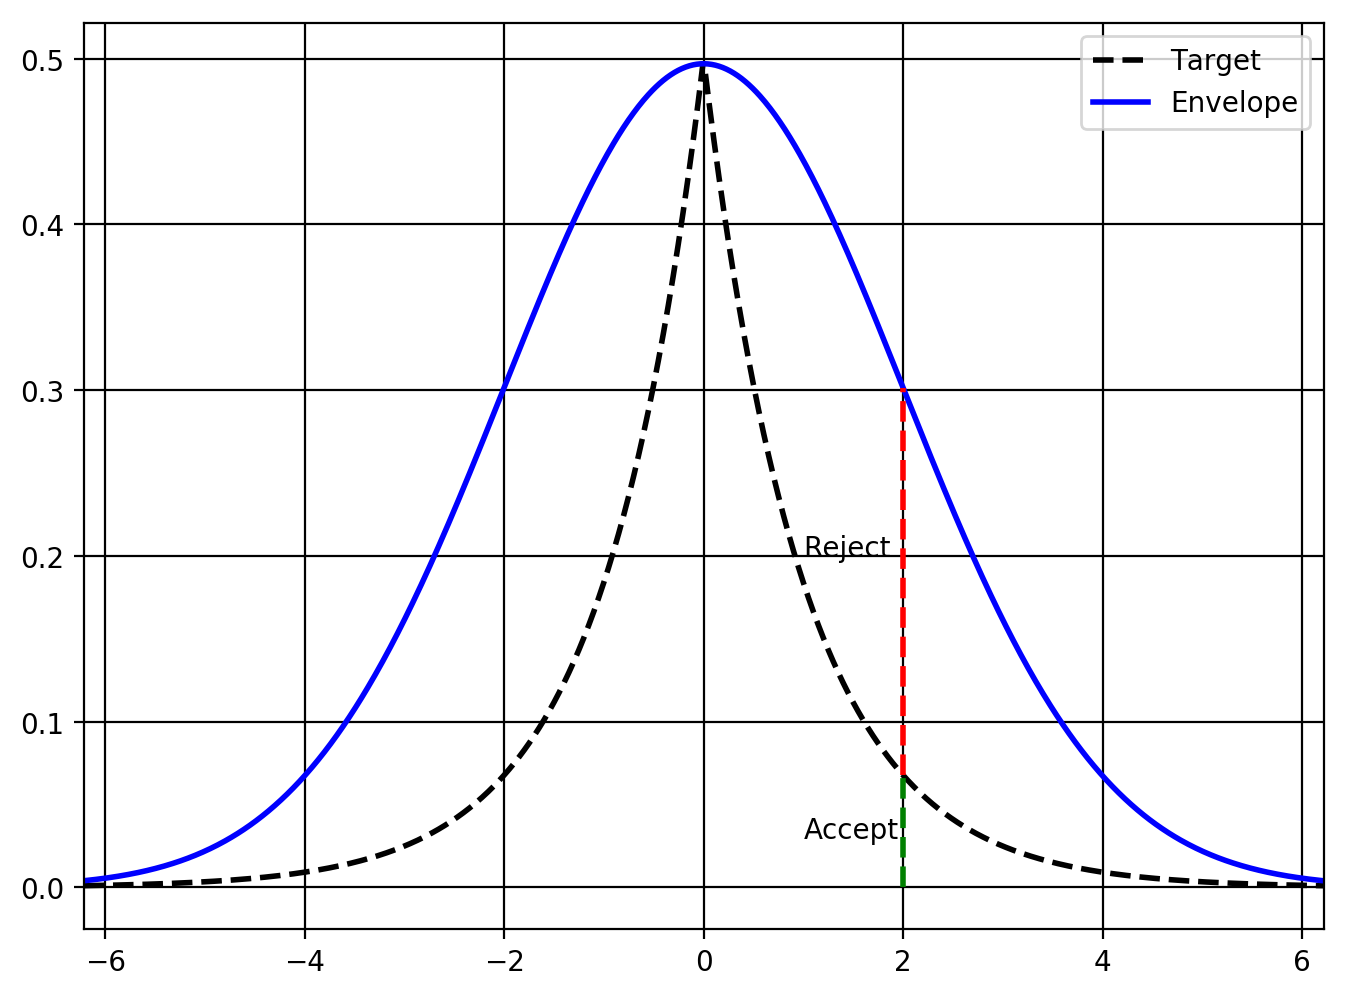

In [36]:
# Target = double gamma distribution
# Envelope = normal distribution 
dg = stats.dgamma(a=1)
norm = stats.norm(loc=0, scale=2)

# Generate samples for PDF
x = np.linspace(min(dg.ppf(0.001), norm.ppf(0.001)), 
                max(dg.ppf(0.999), norm.ppf(0.999)), 1000)
dg_samples = dg.pdf(x)
norm_samples = norm.pdf(x)

# Find scaling constant for envelope 
M = max(dg_samples / norm_samples)

# Plot
df = pd.DataFrame({'Target': dg_samples, 'Envelope': M * norm_samples}, index=x)
ax = df.plot(style=['--', '-'], color=['black', 'blue'], linewidth=2.0, grid=True)
ax.plot((2, 2), (0, dg.pdf(2)), 'g--', linewidth=2.0)
ax.plot((2, 2), (dg.pdf(2), M * norm.pdf(2)), 'r--', linewidth=2.0)
ax.text(1.0, 0.20, 'Reject')
ax.text(1.0, 0.03, 'Accept')

100%|██████████| 10000/10000 [00:04<00:00, 2284.81it/s]


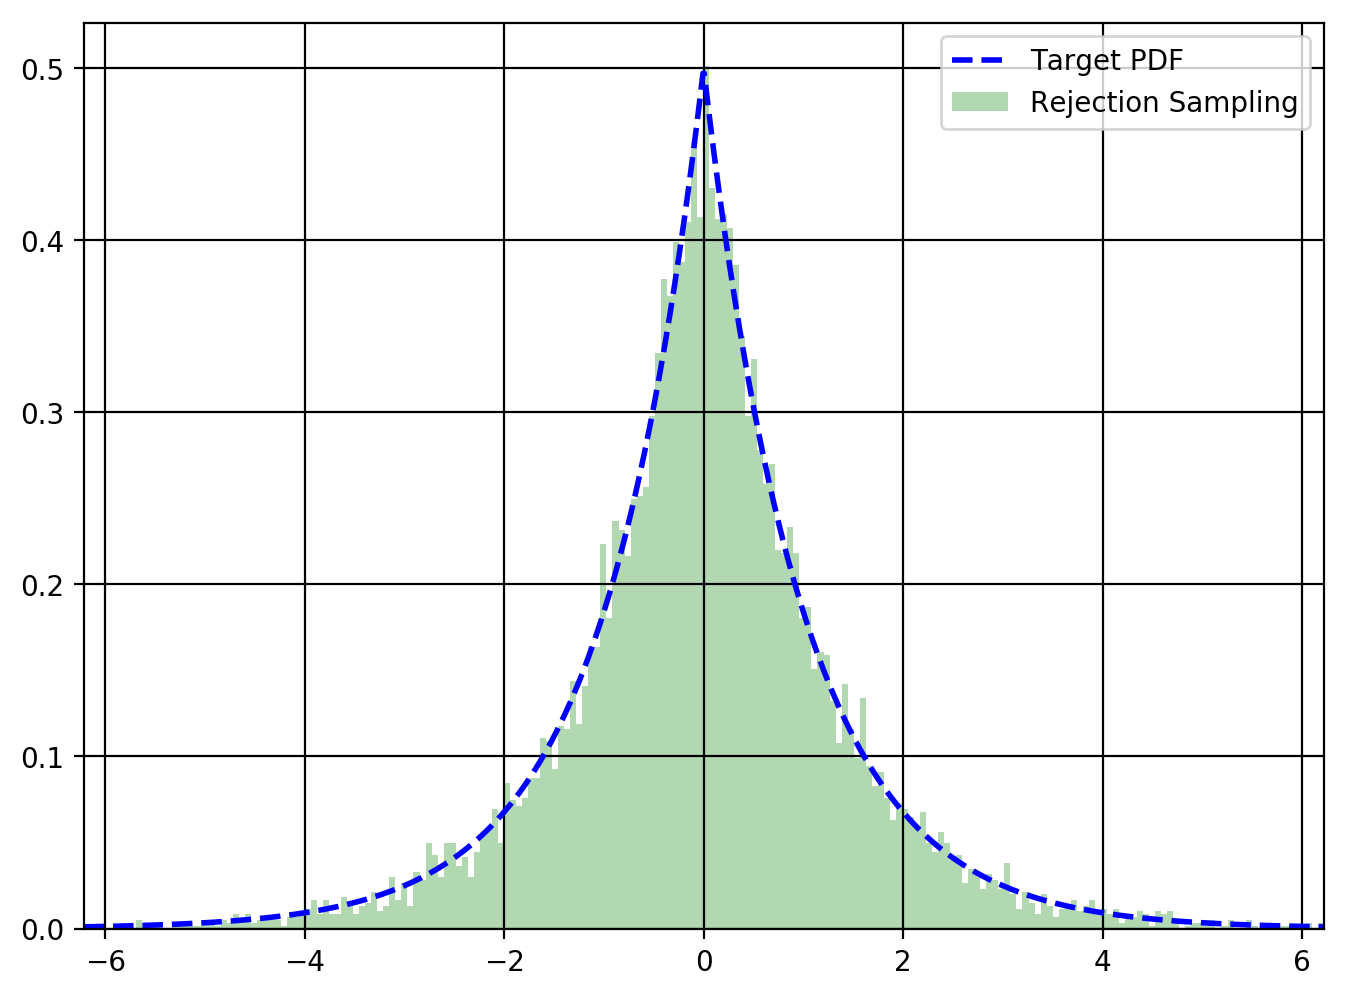

In [37]:
def rejection_sampling():
    while True:
        # Re-use global parameters from above
        x = np.random.normal(0, 2)
        envelope = M * norm.pdf(x)
        p = np.random.uniform(0, envelope)
        if p < dg.pdf(x):
            return x

# Generation samples from rejection sampling algorithm
samples = [rejection_sampling() for x in tqdm(range(10000))]

# Plot Histogram vs. Target PDF
df['Target'].plot(color='blue', style='--', linewidth=2.0)
pd.Series(samples).hist(bins=300, density=True, color='green', 
                        alpha=0.3, linewidth=0.0)
plt.legend(['Target PDF', 'Rejection Sampling']);

## Markov Chain Monte Carlo Technqiues (MCMC)

- A class of algorithms that use Markov Chains to sample from a particular probability distribution (the Monte Carlo part). They work by creating a Markov Chain where the limiting distribution (or stationary distribution) is simply the distribution we want to sample.

<img src="http://bjlkeng.github.io/images/mcmc.png"/>

### 1. Metropolis-Hastings algorithm

### 2. Gibbs sampling

### 3. Hamiltonian Monte Carlo

# 5. Variational Inference

## Mean-field Approximation

---
# Learning

## 1. Learning in directed models

## 2. Learning in undirected models

## 3. Learning in latent variable models

## 4. Bayesian learning

## 5. Structure learning

---
# Variational Autoencoder

---
## Resources:
- [Stanford CS228 class notes](https://ermongroup.github.io/cs228-notes/)
- [Bert Huang of Virginia Tech's ML videos](https://www.youtube.com/playlist?list=PLUenpfvlyoa0rMoE5nXA8kdctBKE9eSob)

### Representation:
- [Berkeley's CS188 AI notes on Bayes net](https://inst.eecs.berkeley.edu/~cs188/sp12/slides/cs188%20lecture%2013%20and%2014%20--%20bayes%20nets%20representation%20and%20independence%202PP.pdf)
- [Hugo Larochelle's videos on CRFs](https://www.youtube.com/playlist?list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH)
- [Implementing a CRF](https://towardsdatascience.com/implementing-a-linear-chain-conditional-random-field-crf-in-pytorch-16b0b9c4b4ea)

### Inference:
- [EM algo in Mixture models context](https://www.youtube.com/watch?v=REypj2sy_5U&list=PLBv09BD7ez_4e9LtmK626Evn1ion6ynrt)
- [EM algo with PLSA (Probabilistic Latent Semantic Analysis)](http://times.cs.uiuc.edu/course/598f16/notes/em-algorithm.pdf)
- [Valentin Wolf's GMM implementation](https://github.com/volflow/Expectation-Maximization/blob/master/9.2%20Mixtures%20of%20Gaussians%20and%20Expectation-Maximization.ipynb)
- [EM algo wiki](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm)
- [Variational Inference VS MCMC](https://www.quora.com/When-should-I-prefer-variational-inference-over-MCMC-for-Bayesian-analysis)
- [Rejction Sampling in Python](https://wiseodd.github.io/techblog/2015/10/21/rejection-sampling/)
- [Real world application of MCMC](https://docs.google.com/spreadsheets/d/1xr6mlgHW1QlAiLAQIS90PJVaVei_ZwgwjYWa-s5LO4M/edit#gid=0)
- [MCMC Wiki](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)
- [Kingma 2015 VAE workshop slides](http://dpkingma.com/wordpress/wp-content/uploads/2015/12/talk_nips_workshop_2015.pdf)
- [Brian Keng's amazing post on Variational Bayes and The Mean-Field Approximation](http://bjlkeng.github.io/posts/variational-bayes-and-the-mean-field-approximation/)
- [Brian Keng on MCMC](http://bjlkeng.github.io/posts/markov-chain-monte-carlo-mcmc-and-the-metropolis-hastings-algorithm/)
- [Stefano Ermon's CS228 Notes](https://ermongroup.github.io/cs228-notes/)

### VAE:
- [VAE Tutorial](https://arxiv.org/pdf/1606.05908.pdf)
- [VAE Pytorch](https://github.com/pytorch/examples/blob/master/vae/main.py)
- [VAE Keras](https://keras.io/examples/variational_autoencoder/)
- [Stanford CS231 Notes on Generative models](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture13.pdf)
- [CMU VAE notes](http://www.cs.cmu.edu/~bhiksha/courses/deeplearning/Spring.2018/www/slides/lec16.vae.pdf)
- [Visualizing MNIST with a Deep Variational Autoencoder](https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder)
- [Collaborative Variational Autoencoder for Recommender Systems](http://eelxpeng.github.io/assets/paper/Collaborative_Variational_Autoencoder.pdf)
- [How Variational Autoencoders make classical recommender systems obsolete.](https://medium.com/snipfeed/how-variational-autoencoders-make-classical-recommender-systems-obsolete-4df8bae51546)
- [Kingma 2015 VAE workshop slides](http://dpkingma.com/wordpress/wp-content/uploads/2015/12/talk_nips_workshop_2015.pdf)
- [Ali Ghodsi lecture on VAE](https://www.youtube.com/watch?v=uaaqyVS9-rM)